In [1]:
import pandas
import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from itertools import product
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
bin_dims = (5, 3)

y_bins = np.linspace(0, 68, bin_dims[1] + 1)  
y_df = pd.DataFrame({"y_bin_start": y_bins[:-1], "y_bin_end": y_bins[1:]})

x_bins = np.linspace(0, 105, bin_dims[0] + 1)
x_df = pd.DataFrame({"x_bin_start": x_bins[:-1], "x_bin_end": x_bins[1:]})

segments_df = pd.DataFrame(
    list(product(
        zip(x_df["x_bin_start"], x_df["x_bin_end"]),
        zip(y_df["y_bin_start"], y_df["y_bin_end"])
    )),
    columns=["x_bins", "y_bins"]
)
segments_df["x_bin_start"], segments_df["x_bin_end"] = zip(*segments_df["x_bins"])
segments_df["y_bin_start"], segments_df["y_bin_end"] = zip(*segments_df["y_bins"])
segments_df = segments_df.drop(columns=["x_bins", "y_bins"])
segments_df['segment'] = segments_df.index + 1


In [3]:
df = pd.read_csv('../00_data/01_actions_data/actions_segmented_5x3.csv')

ball_movements = ['pass', 'cross', 'throw_in', 'goalkick', 'freeckick_crossed', 'freekick_short', 'goal_kick']
attack_moves = ['shot', 'shot_freekick', 'shot_penalty']
defensive_moves = ['interception', 'tackle', 'clearance', 'keeper_save', 'keeper_claim', 'keeper_punch', 'keeper_pick_up', 'keeper_sweeper', 'keeper_success']
graph_df = pd.DataFrame()

game_ids = df['game_id'].unique()

for game in tqdm(game_ids, desc="Games Progress"):
     teams = df[df['game_id'] == game]['team_id'].unique()
     for team in teams:
          team_df = df[(df['game_id'] == game) & (df['team_id'] == team)]
          acts = team_df[team_df['type_name'].isin(ball_movements) & (team_df['result_name'] == 'success')]
          
          G = nx.DiGraph()

          for _, row in acts.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if G.has_edge(player, recipient):
                    G[player][recipient]['weight'] += 1
               else:
                    G.add_edge(player, recipient, weight=1)
          
          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not G.has_edge(u, v):
                    G.add_edge(u, v, weight=0)

          attack_actions = team_df[(team_df['type_name'].isin(attack_moves))]
          attack_G = nx.DiGraph()
          
          for _, row in attack_actions.iterrows():
               player = row['start_segment']
               recipient = row['end_segment']

               if attack_G.has_edge(player, recipient):
                    attack_G[player][recipient]['weight'] += 1
               else:
                    attack_G.add_edge(player, recipient, weight=1)

          for u, v in product(segments_df['segment'], segments_df['segment']):
               if not attack_G.has_edge(u, v):
                    attack_G.add_edge(u, v, weight=0)

          graph_df = pd.concat([graph_df, pd.DataFrame({'game_id':[game] , 'team': [team], 'ball_movements_graph': [G], 'attack_graph': [attack_G]})])

graph_df

Games Progress: 100%|██████████| 1826/1826 [00:40<00:00, 44.93it/s]


,game_id,team,ball_movements_graph,attack_graph
0,2500089,1659,"(11.0, 13.0, 10.0, 9.0, 6.0, 8.0, 1, 2, 3, 4, ...","(11.0, 13.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2500089,1646,"(12.0, 9.0, 11.0, 14.0, 4.0, 7.0, 10.0, 15.0, ...","(5.0, 2.0, 3.0, 14.0, 11.0, 1, 4, 6, 7, 8, 9, ..."
0,2500090,1628,"(8.0, 7.0, 10.0, 11.0, 9.0, 6.0, 14.0, 12.0, 1...","(5.0, 2.0, 4.0, 14.0, 1, 3, 6, 7, 8, 9, 10, 11..."
0,2500090,1627,"(9.0, 11.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13..."
0,2500091,1673,"(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(11.0, 9.0, 10.0, 1, 2, 3, 4, 5, 6, 7, 8, 12, ..."
...,...,...,...,...
0,2565549,692,"(6.0, 9.0, 13.0, 11.0, 8.0, 10.0, 1, 2, 3, 4, ...","(9.0, 11.0, 13.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10..."
0,2565556,674,"(8.0, 12.0, 9.0, 11.0, 10.0, 4.0, 5.0, 13.0, 6...","(2.0, 6.0, 3.0, 1.0, 12.0, 14.0, 15.0, 11.0, 1..."
0,2565556,714,"(8.0, 13.0, 11.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(11.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13..."
0,2565557,696,"(8.0, 11.0, 4.0, 10.0, 12.0, 7.0, 15.0, 9.0, 1...","(3.0, 2.0, 11.0, 14.0, 15.0, 1, 4, 5, 6, 7, 8,..."


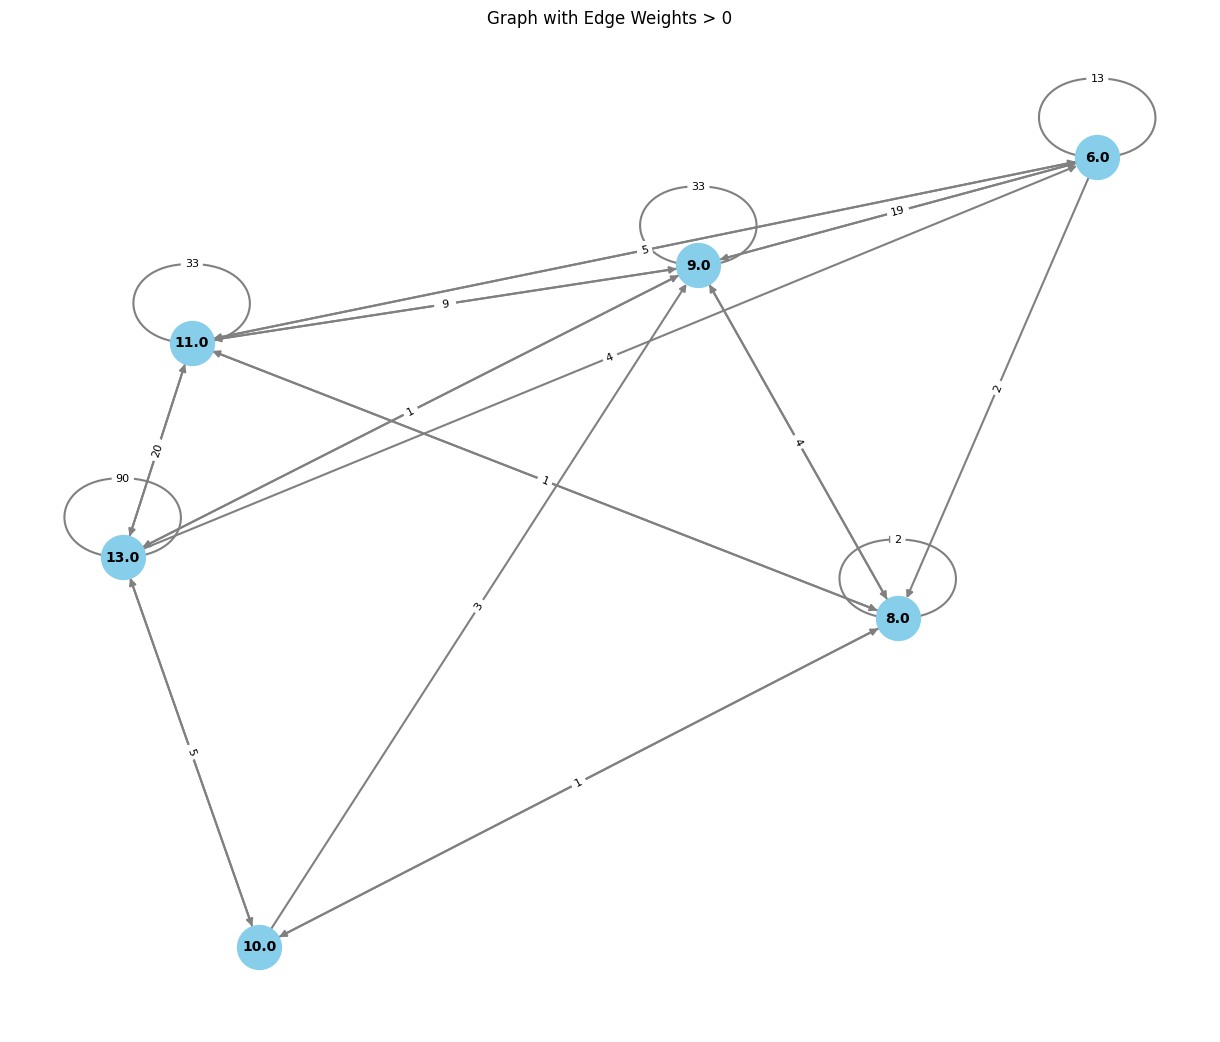

In [4]:
G = graph_df.iloc[0]['ball_movements_graph']

edges_to_draw = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] > 0]

G_filtered = G.edge_subgraph(edges_to_draw)

pos = nx.spring_layout(G_filtered)

plt.figure(figsize=(12, 10))
nx.draw(G_filtered, pos, with_labels=True, font_weight='bold', node_size=1000,
        node_color='skyblue', font_size=10, edge_color='gray',
        width=1.5, arrows=True, arrowstyle='-|>')

edge_labels = nx.get_edge_attributes(G_filtered, 'weight')
nx.draw_networkx_edge_labels(G_filtered, pos, edge_labels=edge_labels, font_size=8)

plt.title("Graph with Edge Weights > 0")
plt.show()

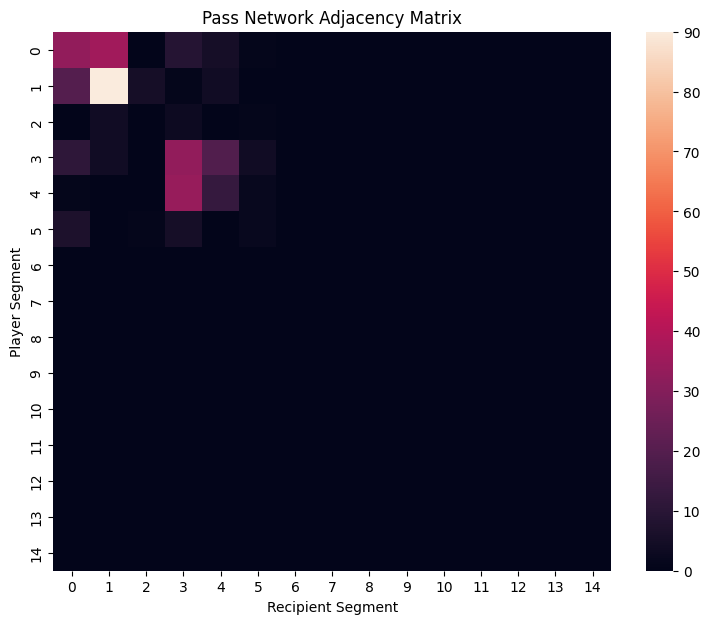

In [5]:
adj = nx.adjacency_matrix(G).todense()

plt.figure(figsize=(9, 7))
sns.heatmap(adj, fmt='d')
plt.xlabel('Recipient Segment')
plt.ylabel('Player Segment')
plt.title('Pass Network Adjacency Matrix')
plt.show()

In [6]:
matches = pd.read_csv('../00_data/01_actions_data/matches.csv')
matches = pd.merge(matches, graph_df, left_on=['game_id', 'home_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'home_team_pass_graph', 'attack_graph': 'home_team_attack_graph'}, inplace=True)

matches = pd.merge(matches, graph_df, left_on=['game_id', 'away_team_id'], right_on=['game_id', 'team'], how='left')
matches.rename(columns={'ball_movements_graph': 'away_team_pass_graph', 'attack_graph': 'away_team_attack_graph'}, inplace=True)

matches = matches[['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result', 'home_team_pass_graph', 'away_team_pass_graph', 'home_team_attack_graph', 'away_team_attack_graph']]

matches.sort_values(by='date', ascending=True, inplace=True)

matches['home_team_prev_mv_graph_1'] = matches.groupby('home_team')['home_team_pass_graph'].shift(1)
matches['away_team_prev_mv_graph_1'] = matches.groupby('away_team')['away_team_pass_graph'].shift(1)

matches['home_team_prev_attack_graph_1'] = matches.groupby('home_team')['home_team_attack_graph'].shift(1)
matches['away_team_prev_attack_graph_1'] = matches.groupby('away_team')['away_team_attack_graph'].shift(1)

matches['home_team_prev_mv_graph_2'] = matches.groupby('home_team')['home_team_pass_graph'].shift(2)
matches['away_team_prev_mv_graph_2'] = matches.groupby('away_team')['away_team_pass_graph'].shift(2)

matches['home_team_prev_attack_graph_2'] = matches.groupby('home_team')['home_team_attack_graph'].shift(2)
matches['away_team_prev_attack_graph_2'] = matches.groupby('away_team')['away_team_attack_graph'].shift(2)

matches['home_team_prev_mv_graph_3'] = matches.groupby('home_team')['home_team_pass_graph'].shift(3)
matches['away_team_prev_mv_graph_3'] = matches.groupby('away_team')['away_team_pass_graph'].shift(3)

matches['home_team_prev_attack_graph_3'] = matches.groupby('home_team')['home_team_attack_graph'].shift(3)
matches['away_team_prev_attack_graph_3'] = matches.groupby('away_team')['away_team_attack_graph'].shift(3)

matches = matches.dropna()
matches

,date,home_team,away_team,home_goals,away_goals,result,home_team_pass_graph,away_team_pass_graph,home_team_attack_graph,away_team_attack_graph,...,home_team_prev_attack_graph_1,away_team_prev_attack_graph_1,home_team_prev_mv_graph_2,away_team_prev_mv_graph_2,home_team_prev_attack_graph_2,away_team_prev_attack_graph_2,home_team_prev_mv_graph_3,away_team_prev_mv_graph_3,home_team_prev_attack_graph_3,away_team_prev_attack_graph_3
255,2017-09-22,Lille,Monaco,0,4,A,"(8.0, 12.0, 7.0, 5.0, 9.0, 14.0, 13.0, 4.0, 1....","(13.0, 10.0, 11.0, 6.0, 9.0, 8.0, 1, 2, 3, 4, ...","(6.0, 2.0, 5.0, 15.0, 14.0, 10.0, 12.0, 1, 3, ...","(10.0, 11.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 8...",...,"(4.0, 2.0, 5.0, 12.0, 14.0, 11.0, 15.0, 1, 3, ...","(10.0, 11.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8...","(8.0, 5.0, 4.0, 1.0, 13.0, 10.0, 2.0, 7.0, 12....","(11.0, 9.0, 8.0, 6.0, 13.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1.0, 6.0, 11.0, 14.0, 12.0, 15.0, 13.0, ...","(11.0, 8.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(8.0, 12.0, 9.0, 6.0, 5.0, 10.0, 4.0, 13.0, 7....","(11.0, 6.0, 9.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(5.0, 2.0, 14.0, 10.0, 11.0, 1, 3, 4, 6, 7, 8,...","(11.0, 9.0, 8.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 10..."
254,2017-09-22,Nice,Angers SCO,2,2,D,"(4.0, 1.0, 9.0, 12.0, 8.0, 5.0, 7.0, 6.0, 11.0...","(11.0, 13.0, 9.0, 6.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 1.0, 10.0, 11.0, 14.0, 3, 4, 6, 7, ...","(13.0, 11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, ...",...,"(4.0, 2.0, 1.0, 14.0, 3, 5, 6, 7, 8, 9, 10, 11...","(10.0, 11.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 12...","(14.0, 15.0, 12.0, 9.0, 10.0, 11.0, 8.0, 7.0, ...","(11.0, 9.0, 13.0, 6.0, 8.0, 10.0, 1, 2, 3, 4, ...","(3.0, 2.0, 5.0, 14.0, 11.0, 12.0, 1, 4, 6, 7, ...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13...","(14.0, 11.0, 10.0, 7.0, 12.0, 8.0, 4.0, 5.0, 6...","(6.0, 9.0, 11.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 1.0, 11.0, 14.0, 15.0, 12.0, 3, 4, ...","(10.0, 11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6,..."
259,2017-09-23,Juventus,Torino,4,0,H,"(8.0, 11.0, 12.0, 14.0, 15.0, 6.0, 9.0, 10.0, ...","(11.0, 8.0, 13.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(1.0, 2.0, 5.0, 4.0, 10.0, 14.0, 11.0, 3, 6, 7...","(11.0, 13.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10...",...,"(5.0, 2.0, 6.0, 11.0, 12.0, 14.0, 1, 3, 4, 7, ...","(11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(11.0, 8.0, 7.0, 12.0, 14.0, 5.0, 15.0, 10.0, ...","(9.0, 6.0, 13.0, 10.0, 8.0, 11.0, 1, 2, 3, 4, ...","(5.0, 4.0, 2.0, 13.0, 14.0, 11.0, 1, 3, 6, 7, ...","(11.0, 13.0, 8.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 10...","(12.0, 9.0, 14.0, 7.0, 4.0, 5.0, 10.0, 1.0, 2....","(6.0, 9.0, 11.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 14.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12...","(11.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 10, 12, ..."
266,2017-09-23,Olympique Lyonnais,Dijon,3,3,D,"(8.0, 11.0, 13.0, 10.0, 14.0, 15.0, 9.0, 4.0, ...","(11.0, 6.0, 9.0, 13.0, 10.0, 8.0, 1, 2, 3, 4, ...","(3.0, 2.0, 1.0, 5.0, 14.0, 11.0, 4, 6, 7, 8, 9...","(11.0, 10.0, 8.0, 9.0, 13.0, 1, 2, 3, 4, 5, 6,...",...,"(5.0, 2.0, 4.0, 6.0, 12.0, 14.0, 11.0, 10.0, 1...","(9.0, 11.0, 10.0, 8.0, 1, 2, 3, 4, 5, 6, 7, 12...","(12.0, 14.0, 10.0, 9.0, 13.0, 7.0, 11.0, 8.0, ...","(11.0, 13.0, 9.0, 8.0, 10.0, 6.0, 1, 2, 3, 4, ...","(3.0, 2.0, 7.0, 13.0, 14.0, 11.0, 1, 4, 5, 6, ...","(8.0, 11.0, 10.0, 13.0, 9.0, 1, 2, 3, 4, 5, 6,...","(10.0, 7.0, 4.0, 3.0, 9.0, 6.0, 8.0, 11.0, 14....","(13.0, 11.0, 9.0, 10.0, 8.0, 6.0, 1, 2, 3, 4, ...","(2.0, 5.0, 3.0, 1.0, 14.0, 12.0, 4, 6, 7, 8, 9...","(8.0, 11.0, 10.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 12..."
267,2017-09-23,Caen,Amiens SC,1,0,H,"(15.0, 6.0, 10.0, 12.0, 9.0, 4.0, 14.0, 8.0, 7...","(9.0, 6.0, 13.0, 11.0, 10.0, 8.0, 1, 2, 3, 4, ...","(6.0, 2.0, 1.0, 5.0, 4.0, 14.0, 12.0, 10.0, 3,...","(11.0, 9.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13...",...,"(2.0, 8.0, 5.0, 10.0, 11.0, 14.0, 13.0, 1, 3, ...","(8.0, 11.0, 13.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, ...","(8.0, 11.0, 4.0, 9.0, 6.0, 7.0, 3.0, 10.0, 5.0...","(11.0, 13.0, 9.0, 6.0, 10.0, 8.0, 1, 2, 3, 4, ...","(2.0, 5.0, 14.0, 11.0, 1, 3, 4

In [7]:
def mean_graph(graphs):
     G = nx.DiGraph()
     for graph in graphs:
          for u, v, d in graph.edges(data=True):
               if G.has_edge(u, v):
                    G[u][v]['weight'] += d['weight']
               else:
                    G.add_edge(u, v, weight=d['weight'])
     
     return G

matches['home_team_mean_pass_graph'] = matches[['home_team_prev_mv_graph_1', 'home_team_prev_mv_graph_2', 'home_team_prev_mv_graph_3']].apply(mean_graph, axis=1)
matches['away_team_mean_pass_graph'] = matches[['away_team_prev_mv_graph_1', 'away_team_prev_mv_graph_2', 'away_team_prev_mv_graph_3']].apply(mean_graph, axis=1)

matches['home_team_mean_attack_graph'] = matches[['home_team_prev_attack_graph_1', 'home_team_prev_attack_graph_2', 'home_team_prev_attack_graph_3']].apply(mean_graph, axis=1)
matches['away_team_mean_attack_graph'] = matches[['away_team_prev_attack_graph_1', 'away_team_prev_attack_graph_2', 'away_team_prev_attack_graph_3']].apply(mean_graph, axis=1)

matches[['date', 'home_team', 'away_team', 'home_goals', 'away_goals', 'result', 'home_team_mean_pass_graph', 'away_team_mean_pass_graph', 'home_team_mean_attack_graph', 'away_team_mean_attack_graph']]

,date,home_team,away_team,home_goals,away_goals,result,home_team_mean_pass_graph,away_team_mean_pass_graph,home_team_mean_attack_graph,away_team_mean_attack_graph
255,2017-09-22,Lille,Monaco,0,4,A,"(12.0, 15.0, 14.0, 9.0, 8.0, 11.0, 3.0, 6.0, 7...","(11.0, 8.0, 9.0, 13.0, 6.0, 10.0, 1, 2, 3, 4, ...","(4.0, 2.0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13...","(10.0, 11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13..."
254,2017-09-22,Nice,Angers SCO,2,2,D,"(7.0, 10.0, 11.0, 4.0, 13.0, 5.0, 1, 2, 3, 6, ...","(13.0, 10.0, 11.0, 9.0, 8.0, 1, 2, 3, 4, 5, 6,...","(4.0, 2.0, 1, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13...","(10.0, 11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13..."
259,2017-09-23,Juventus,Torino,4,0,H,"(4.0, 5.0, 7.0, 1.0, 8.0, 10.0, 2, 3, 6, 9, 11...","(11.0, 9.0, 13.0, 8.0, 6.0, 10.0, 1, 2, 3, 4, ...","(5.0, 2.0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13...","(11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, ..."
266,2017-09-23,Olympique Lyonnais,Dijon,3,3,D,"(9.0, 6.0, 12.0, 11.0, 5.0, 8.0, 13.0, 3.0, 15...","(11.0, 9.0, 10.0, 6.0, 13.0, 8.0, 1, 2, 3, 4, ...","(5.0, 2.0, 1, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13...","(9.0, 11.0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 12, 13..."
267,2017-09-23,Caen,Amiens SC,1,0,H,"(12.0, 5.0, 4.0, 10.0, 11.0, 8.0, 9.0, 14.0, 1...","(11.0, 8.0, 13.0, 9.0, 6.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, ...","(8.0, 11.0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 12, 13..."
...,...,...,...,...,...,...,...,...,...,...
1815,2018-05-20,Athletic Club,Espanyol,0,1,A,"(10.0, 11.0, 7.0, 4.0, 8.0, 1.0, 14.0, 5.0, 13...","(9.0, 6.0, 8.0, 13.0, 11.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, ...","(11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, ..."
1814,2018-05-20,Valencia,Deportivo La Coruña,2,1,H,"(8.0, 11.0, 4.0, 9.0, 5.0, 7.0, 6.0, 10.0, 12....","(9.0, 11.0, 6.0, 8.0, 13.0, 10.0, 1, 2, 3, 4, ...","(2.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, ...","(13.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, ..."
1813,2018-05-20,Genoa,Torino,1,2,A,"(13.0, 14.0, 10.0, 7.0, 11.0, 1, 2, 3, 4, 5, 6...","(13.0, 11.0, 9.0, 10.0, 1, 2, 3, 4, 5, 6, 7, 8...","(2.0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, ...","(11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, ..."
1818,2018-05-20,Sassuolo,Roma,0,1,A,"(10.0, 12.0, 4.0, 11.0, 7.0, 8.0, 13.0, 3.0, 1...","(11.0, 9.0, 10.0, 13.0, 8.0, 6.0, 1, 2, 3, 4, ...","(5.0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, ...","(10.0, 11.0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 12, 13..."


In [8]:
import torch
import torch_geometric
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def from_networkx(graph):
    edge_index = torch.tensor(list(graph.edges)).t().contiguous()
    edge_weight = torch.tensor([graph[u][v]['weight'] for u, v in graph.edges], dtype=torch.float32)
    
    data = Data(edge_index=edge_index, edge_attr=edge_weight)
    data.num_nodes = graph.number_of_nodes()
    
    return data

def to_data(graph):
    graph = nx.convert_node_labels_to_integers(graph)
    data = from_networkx(graph)
    if 'x' not in data:
        data.x = torch.ones((graph.number_of_nodes(), 1))
    return data


le = LabelEncoder()
matches['result'] = le.fit_transform(matches['result'])

X_train, X_test, y_train, y_test = train_test_split(
    matches[['home_team_mean_pass_graph', 'away_team_mean_pass_graph',
             'home_team_mean_attack_graph', 'away_team_mean_attack_graph']],
    matches['result'],
    test_size=0.3,
    random_state=42
)

X_train_home_pass = [to_data(g) for g in X_train['home_team_mean_pass_graph']]
X_train_away_pass = [to_data(g) for g in X_train['away_team_mean_pass_graph']]
X_train_home_attack = [to_data(g) for g in X_train['home_team_mean_attack_graph']]
X_train_away_attack = [to_data(g) for g in X_train['away_team_mean_attack_graph']]

X_test_home_pass = [to_data(g) for g in X_test['home_team_mean_pass_graph']]
X_test_away_pass = [to_data(g) for g in X_test['away_team_mean_pass_graph']]
X_test_home_attack = [to_data(g) for g in X_test['home_team_mean_attack_graph']]
X_test_away_attack = [to_data(g) for g in X_test['away_team_mean_attack_graph']]

def collate_fn(batch):
    home_pass = [item[0] for item in batch]
    home_attack = [item[1] for item in batch]
    away_pass = [item[2] for item in batch]
    away_attack = [item[3] for item in batch]
    targets = [item[4] for item in batch]
    
    return (
        Batch.from_data_list(home_pass),
        Batch.from_data_list(home_attack),
        Batch.from_data_list(away_pass),
        Batch.from_data_list(away_attack),
        torch.tensor(targets, dtype=torch.long)
    )

train_data = list(zip(
    X_train_home_pass, 
    X_train_home_attack,
    X_train_away_pass,
    X_train_away_attack,
    y_train
))

test_data = list(zip(
    X_test_home_pass,
    X_test_home_attack,
    X_test_away_pass,
    X_test_away_attack,
    y_test
))

train_loader = torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True, collate_fn=collate_fn)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=16, shuffle=False, collate_fn=collate_fn)

class MultiGraphGNN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 32)
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.3),
            torch.nn.Linear(64, 3)
        )

    def forward(self, home_pass, home_attack, away_pass, away_attack):
        def process_graph(graph):
            x = self.conv1(graph.x, graph.edge_index)
            x = torch.relu(x)
            x = self.conv2(x, graph.edge_index)
            return global_mean_pool(x, graph.batch)
        
        hp = process_graph(home_pass)
        ha = process_graph(home_attack)
        ap = process_graph(away_pass)
        aa = process_graph(away_attack)
        
        combined = torch.cat([hp, ha, ap, aa], dim=1)
        return self.fc(combined)

model = MultiGraphGNN().to(device)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train():
    model.train()
    total_loss = 0
    for home_pass, home_attack, away_pass, away_attack, targets in train_loader:
        home_pass = home_pass.to(device)
        home_attack = home_attack.to(device)
        away_pass = away_pass.to(device)
        away_attack = away_attack.to(device)
        targets = targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(home_pass, home_attack, away_pass, away_attack)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test():
    model.eval()
    correct = 0
    with torch.no_grad():
        for home_pass, home_attack, away_pass, away_attack, targets in test_loader:
            home_pass = home_pass.to(device)
            home_attack = home_attack.to(device)
            away_pass = away_pass.to(device)
            away_attack = away_attack.to(device)
            targets = targets.to(device)
            
            outputs = model(home_pass, home_attack, away_pass, away_attack)
            pred = outputs.argmax(dim=1)
            correct += (pred == targets).sum().item()
    
    return correct / len(test_loader.dataset)

for epoch in range(100):
    loss = train()
    acc = test()
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")

Epoch: 000, Loss: 1.0795, Accuracy: 0.4471
Epoch: 001, Loss: 1.0698, Accuracy: 0.4471
Epoch: 002, Loss: 1.0715, Accuracy: 0.4471
Epoch: 003, Loss: 1.0655, Accuracy: 0.4471
Epoch: 004, Loss: 1.0691, Accuracy: 0.4471
Epoch: 005, Loss: 1.0684, Accuracy: 0.4471
Epoch: 006, Loss: 1.0643, Accuracy: 0.4471
Epoch: 007, Loss: 1.0627, Accuracy: 0.4471
Epoch: 008, Loss: 1.0626, Accuracy: 0.4471
Epoch: 009, Loss: 1.0654, Accuracy: 0.4471
Epoch: 010, Loss: 1.0635, Accuracy: 0.4471
Epoch: 011, Loss: 1.0614, Accuracy: 0.4471
Epoch: 012, Loss: 1.0610, Accuracy: 0.4471
Epoch: 013, Loss: 1.0621, Accuracy: 0.4471
Epoch: 014, Loss: 1.0667, Accuracy: 0.4471
Epoch: 015, Loss: 1.0631, Accuracy: 0.4471
Epoch: 016, Loss: 1.0625, Accuracy: 0.4471
Epoch: 017, Loss: 1.0665, Accuracy: 0.4471
Epoch: 018, Loss: 1.0624, Accuracy: 0.4471
Epoch: 019, Loss: 1.0642, Accuracy: 0.4471
Epoch: 020, Loss: 1.0620, Accuracy: 0.4471
Epoch: 021, Loss: 1.0638, Accuracy: 0.4471
Epoch: 022, Loss: 1.0610, Accuracy: 0.4471
Epoch: 023,

In [9]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATConv, global_mean_pool

class MultiGraphGAT(torch.nn.Module):
    def __init__(self, num_features=1, num_classes=3):
        super().__init__()
        self.gat1 = GATConv(
            in_channels=num_features,
            out_channels=8,
            heads=4,
            dropout=0.3
        )
    
        self.gat2 = GATConv(
            in_channels=8*4,
            out_channels=32,
            heads=1,
            dropout=0.3
        )
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(128, 64),
            torch.nn.ELU(),
            torch.nn.Dropout(0.4),
            torch.nn.Linear(64, num_classes))
                
        self.attention_dropout = torch.nn.Dropout(0.3)

    def process_graph(self, graph):
        x = F.elu(self.gat1(graph.x, graph.edge_index))
        x = self.attention_dropout(x)
        x = self.gat2(x, graph.edge_index)
        return global_mean_pool(x, graph.batch)

    def forward(self, home_pass, home_attack, away_pass, away_attack):
        hp = self.process_graph(home_pass)
        ha = self.process_graph(home_attack)
        ap = self.process_graph(away_pass)
        aa = self.process_graph(away_attack)
        
        combined = torch.cat([hp, ha, ap, aa], dim=1)
        return self.fc(combined)


model = MultiGraphGAT(num_features=1).to(device)

for epoch in range(100):
    loss = train()
    acc = test()
    print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, Accuracy: {acc:.4f}")


Epoch: 000, Loss: 1.1010, Accuracy: 0.2709
Epoch: 001, Loss: 1.1020, Accuracy: 0.2709
Epoch: 002, Loss: 1.1004, Accuracy: 0.2709
Epoch: 003, Loss: 1.1023, Accuracy: 0.2709
Epoch: 004, Loss: 1.0990, Accuracy: 0.2709
Epoch: 005, Loss: 1.1058, Accuracy: 0.2709
Epoch: 006, Loss: 1.1038, Accuracy: 0.2709
Epoch: 007, Loss: 1.1016, Accuracy: 0.2709
Epoch: 008, Loss: 1.1000, Accuracy: 0.2709
Epoch: 009, Loss: 1.1035, Accuracy: 0.2709
Epoch: 010, Loss: 1.1057, Accuracy: 0.2709
Epoch: 011, Loss: 1.1004, Accuracy: 0.2709
Epoch: 012, Loss: 1.1018, Accuracy: 0.2709
Epoch: 013, Loss: 1.1012, Accuracy: 0.2709
Epoch: 014, Loss: 1.1020, Accuracy: 0.2709
Epoch: 015, Loss: 1.1009, Accuracy: 0.2709
Epoch: 016, Loss: 1.1006, Accuracy: 0.2709
Epoch: 017, Loss: 1.1035, Accuracy: 0.2709
Epoch: 018, Loss: 1.1014, Accuracy: 0.2709
Epoch: 019, Loss: 1.1015, Accuracy: 0.2709
Epoch: 020, Loss: 1.1011, Accuracy: 0.2709
Epoch: 021, Loss: 1.1039, Accuracy: 0.2709
Epoch: 022, Loss: 1.1008, Accuracy: 0.2709
Epoch: 023,